## EDA

In [1]:
import os
import wandb
import warnings
from hparams import *
import numpy as np
import math
import pandas as pd 
import seaborn as sns
from models import  *
from utils import train_model,set_seeds,create_dataset_from_file
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.metrics import mean_absolute_error
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_absolute_error
set_seeds(42)
warnings.filterwarnings('ignore')
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"]="1" # 1 for run in gpu -1 for run in cpu
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['TF_GPU_ALLOCATOR'] ='cuda_malloc_async' 
%reload_ext autoreload
%autoreload 2


2023-02-13 11:11:49.410208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 11:11:50.598710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.7/lib64:
2023-02-13 11:11:50.598784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.7/lib64:
2023-02-13 11:11:50.598790: W 

In [2]:
#loading dataframes
train_df = pd.read_csv('../data/Bone Age Training Set/train.csv')
df_test = pd.read_excel('../data/Bone Age Test Set/test.xlsx')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
df_test['Case ID'] = df_test['Case ID'].apply(lambda x: str(x)+'.png') 
df_test.rename(columns={'Ground truth bone age (months)': 'boneage','Sex':'gender'}, inplace=True)

train_df['img_path'] = train_df['id'].apply(lambda x: '../data/Bone Age Training Set/boneage-training-dataset/'+str(x))
df_test['img_path'] = df_test['Case ID'].apply(lambda x: '../data/Bone Age Test Set/boneage-testing-dataset/'+str(x)) 

#train_df = train_df.head(200)

male      6833
female    5778
Name: gender, dtype: int64


<AxesSubplot:xlabel='gender', ylabel='count'>

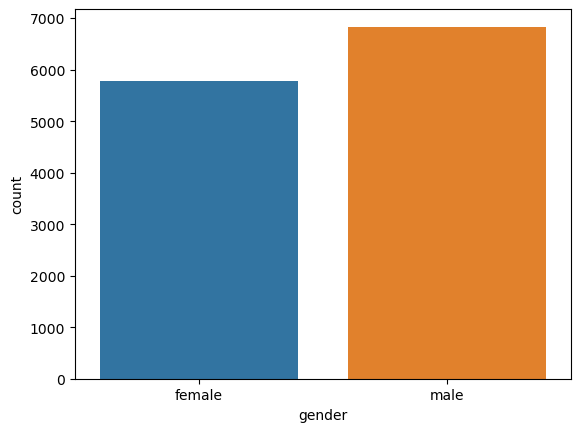

In [3]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [4]:
# convert ctegorical to numeric
train_df['gender'].replace(['male', 'female'],[1, 0], inplace=True)
df_test['gender'].replace(['M', 'F'],[0, 1], inplace=True)

In [5]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  \
0  1377.png      180  False   
1  1378.png       12  False   
2  1379.png       94  False   
3  1380.png      120   True   
4  1381.png       82  False   

                                            img_path  gender  bone_age_z  
0  ../data/Bone Age Training Set/boneage-training...       0    1.279181  
1  ../data/Bone Age Training Set/boneage-training...       0   -2.800269  
2  ../data/Bone Age Training Set/boneage-training...       0   -0.809109  
3  ../data/Bone Age Training Set/boneage-training...       1   -0.177766  
4  ../data/Bone Age Training Set/boneage-training...       0   -1.100498  


In [7]:
std_bone_age

41.18202139939618

In [8]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

Text(0.5, 1.0, 'Number of children in each age group')

## Preprocess

In [9]:
#splitting train dataframe into traininng and validation dataframes
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

In [10]:
train_steps = int(np.ceil(len(df_train) / hparams.BATCH_SIZE))
val_steps = int(np.ceil(len(df_valid) / hparams.BATCH_SIZE))
train_dataset=create_dataset_from_file(df_train["img_path"],df_train['gender'].to_numpy().reshape(-1,1),df_train[hparams.TARGET_VAR].to_numpy().reshape(-1,1))
val_dataset=create_dataset_from_file(df_valid["img_path"],df_valid['gender'].to_numpy().reshape(-1,1),df_valid[hparams.TARGET_VAR].to_numpy().reshape(-1,1))
test_dataset=create_dataset_from_file(df_test["img_path"],df_test['gender'].to_numpy().reshape(-1,1),df_test[hparams.TARGET_VAR].to_numpy().reshape(-1,1))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:

def mae_in_months(x_p, y_p):
    """function to return mae in months"""
    return mean_absolute_error(
        (std_bone_age * x_p + mean_bone_age), (std_bone_age * y_p + mean_bone_age)
    )

model 1 = baseline, 2 = baseline_attention, 3 = unet, 
      4 = residual_attention_unet, 5= inception_attention_unet,
      6 = cnn_attention_unet

submodel for only model 2

submodel 1= one_attention_output_attention, 2= one_attention_output_cnn
         3= all_attention_output_attention, 4 = all_attention_output_cnn

In [4]:
if hparams.NORMALIZE_OUTPUT == True:
    metric = ['mae_in_months']
else:
    metric = ['mse']

if hparams.MODEL_NO == 1:
    hparams.MODEL_NAME = "baseline"
    model = BaselineCnn.baseline_cnn()
    
elif hparams.MODEL_NO == 2:
    hparams.MODEL_NAME = "baseline_attention_"+str(hparams.SUB_MODEL_NO)
    model =  BaselineCnnAttention.baseline_cnn_attention(hparams.SUB_MODEL_NO)

elif hparams.MODEL_NO == 3:
    model = Unet.unet()
    hparams.MODEL_NAME = "unet"

elif hparams.MODEL_NO == 4:
    model = ResidualAttentionUnet.residual_attention_unet()
    hparams.MODEL_NAME = "residual_attention_unet" 
elif hparams.MODEL_NO == 5:
    model = InceptionAttentionUnet.inception_attention_unet()
    hparams.MODEL_NAME = "inception_attention_unet" 
elif hparams.MODEL_NO == 6:
    model = CnnAttentionUnet.cnn_attention_unet()
    hparams.MODEL_NAME = "cnn_attention_unet" 

model.compile(loss ='mse', optimizer= 'adam',metrics = metric)
#model.compile(loss ='mse', optimizer= 'adam')
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 256, 256, 16  64         ['conv2d_23[0][0]']              
 ormalization)                  )                                                           

In [32]:
wandb.init(
        project=hparams.PROJECT_NAME,
        entity="hda-project",
        name=hparams.MODEL_NAME
        # notes=hparams.NOTES
    )
wandb.config.update(hparams.CONFIG)

epoch,▁
loss,▁
lr,▁
mse,▁
test_mse,▁
val_loss,▁
val_mse,▁
best_epoch,0
best_val_loss,6478.83984
epoch,0
loss,11293.20508


In [33]:
if hparams.GENDER:
    hparams.MODEL_NAME = hparams.MODEL_NAME+"_gender"
    
history = train_model(model, train_dataset, val_dataset, train_steps,val_steps)

wandb.config.update({"MODEL_NAME":hparams.MODEL_NAME})

631/631 [==============================] - 2818s 4s/step - loss: 1707.6287 - mse: 1707.6287 - val_loss: 1420.4620 - val_mse: 1420.4620 - lr: 0.0010


In [34]:
art = wandb.Artifact(hparams.MODEL_NAME+"_best_model", type="model")
art.add_file("../data/artifact/" + hparams.MODEL_NAME + ".h5")
wandb.log_artifact(art)

## Evaluation

import wandb
run = wandb.init()
artifact = run.use_artifact('hda-project/prod-100/unet_best_model:v0', type='model')
artifact_dir = artifact.download()


In [17]:
df_test['gender'].to_numpy().reshape(-1,1)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [14]:
from tensorflow import keras
model = keras.models.load_model('data/artifact/unet.h5')

In [15]:
test_y = df_test[hparams.TARGET_VAR].to_numpy()
pred_y =model.predict(test_dataset)
mse_value = mean_squared_error(test_y,pred_y)
wandb.log({"test_mse":mse_value})

13/13 [==============================] - 12s 792ms/step


## Garbage

In [37]:
# x = train_df['img_path'].tolist()
# y = train_df['boneage'].tolist()
#x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
# train_dataset = create_dataset(x_train, y_train,
#                                batch_size=hparams.BATCH_SIZE,
#                                shuffle=True,
#                                cache_file=hparams.TRAIN_CACHE_PATH)

# val_dataset = create_dataset(x_val, y_val,
#                               batch_size=hparams.BATCH_SIZE,
#                               shuffle=False,
#                               cache_file=hparams.VAL_CACHE_PATH)

# train_steps = int(np.ceil(len(x_train) / hparams.BATCH_SIZE))
# val_steps = int(np.ceil(len(x_val) / hparams.BATCH_SIZE))

In [38]:
#wandb.save("../data/artifact/" + hparams.MODEL_NAME + ".h5")
# art = wandb.Artifact("best_model", type="model")
# art.add_file("../data/artifact/" + hparams.MODEL_NAME + ".h5")
# wandb.log_artifact(art)

In [39]:

# model = AutoEncoder.auto_encoder()
# model.compile(loss ='mse', optimizer= 'adam',metrics = ['mse'])
# #model.compile(loss ='mse', optimizer= 'adam')
# model.summary()
# history = train_model(model, train_dataset, val_dataset,train_steps,val_steps)

## Checking GPU Status

import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

https://github.com/philipperemy/keras-attention-mechanism
https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831
https://github.com/bnsreenu/python_for_microscopists
https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py
https://github.com/robinvvinod/unet
https://www.datacamp.com/tutorial/autoencoder-classifier-python
https://www.kaggle.com/code/kmader/attention-on-pretrained-vgg16-for-bone-age
https://stackoverflow.com/questions/52582275/tf-data-with-multiple-inputs-outputs-in-keras





In [2]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu_devices[0], True)
# TF_FORCE_GPU_ALLOW_GROWTH=true
gpu_devices

[]

In [41]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# img = mpimg.imread('../data/Bone Age Training Set/boneage-training-dataset/1381.png')
# plt.imshow(img)
# print(img.shape)

if hparams.GENDER:
    train_generator.reset()
    train_x,train_y = next(train_generator)

    for i in range((math.ceil(len(df_train)/train_batch_size))-1):
        tmp_x,tmp_y = next(train_generator)
        train_x = np.concatenate((train_x,tmp_x),axis=0)
        train_y = np.concatenate((train_y,tmp_y),axis=0)
        print("in train")
    
    val_generator.reset()
    val_x,val_y = next(val_generator)
    print("done")
    for i in range((math.ceil(len(df_valid)/val_batch_size))-1):
        tmp_x,tmp_y = next(val_generator)
        val_x = np.concatenate((val_x,tmp_x),axis=0)
        val_y = np.concatenate((val_y,tmp_y),axis=0)

    test_generator.reset()
    test_x = next(test_generator)

    for i in range((math.ceil(len(df_test)/test_batch_size))-1):
        tmp_x = next(test_generator)
        test_x = np.concatenate((test_x,tmp_x),axis=0)
        

    gend_train_x =(df_train['gender'].to_numpy()).reshape(-1,1)
    gend_val_x =(df_valid['gender'].to_numpy()).reshape(-1,1)
    gend_test_x =(df_test['gender'].to_numpy()).reshape(-1,1)
    hparams.MODEL_NAME = hparams.MODEL_NAME+"_gender"

In [42]:
config = hparams.CONFIG
config["project"] = hparams.PROJECT_NAME
config["entity"] = "hda-project"
config["name"] = hparams.MODEL_NAME

wandb.init(config=config)

epoch,▁
loss,▁
lr,▁
mse,▁
test_mse,▁
val_loss,▁
val_mse,▁
best_epoch,0
best_val_loss,1420.46204
epoch,0
loss,1707.62866


In [4]:
import tensorflow as tf 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Please install GPU version of TF


In [ ]:
import math
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.metrics import mean_absolute_error
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import wandb
from hparams import *
from models import *
from utils import create_dataset_from_file, set_seeds, train_model

set_seeds(42)
warnings.filterwarnings("ignore")
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 1 for run in gpu -1 for run in cpu
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['TF_GPU_ALLOCATOR'] ='cuda_malloc_async'


# loading dataframes
df_train = pd.read_csv("data/Bone Age Training Set/train.csv")
df_test = pd.read_excel("data/Bone Age Test Set/test.xlsx")
df_valid = pd.read_csv("data/Bone Age Validation Set/Validation Dataset.csv")


# appending file extension to id column for both training and testing dataframes
df_train["id"] = df_train["id"].apply(lambda x: str(x) + ".png")
df_test["Case ID"] = df_test["Case ID"].apply(lambda x: str(x) + ".png")
df_valid["Image ID"] = df_valid["Image ID"].apply(lambda x: str(x) + ".png")
df_test.rename(
    columns={"Ground truth bone age (months)": "boneage", "Sex": "gender"}, inplace=True
)

df_valid.rename(
    columns={"Bone Age (months)": "boneage", "male": "gender"}, inplace=True
)


df_train["img_path"] = df_train["id"].apply(
    lambda x: "data/Bone Age Training Set/boneage-training-dataset/" + str(x)
)
df_test["img_path"] = df_test["Case ID"].apply(
    lambda x: "data/Bone Age Test Set/boneage-testing-dataset/" + str(x)
)

df_valid["img_path"] = df_valid["Image ID"].apply(
    lambda x: "data/Bone Age Validation Set/boneage-validation-dataset/" + str(x)
)


df_train["gender"] = df_train["male"].apply(lambda x: "male" if x else "female")
df_train["gender"].replace(["male", "female"], [1, 0], inplace=True)
df_test["gender"].replace(["M", "F"], [1, 0], inplace=True)
df_valid["gender"].replace([True, False], [1, 0], inplace=True)



# mean age is
mean_bone_age = df_train["boneage"].mean()
# standard deviation of boneage
std_bone_age = df_train["boneage"].std()

# using z score for the training
df_train["bone_age_z"] = (df_train["boneage"] - mean_bone_age) / (std_bone_age)
df_test["bone_age_z"] = (df_test["boneage"] - mean_bone_age) / (std_bone_age)
df_valid["bone_age_z"] = (df_valid["boneage"] - mean_bone_age) / (std_bone_age)

# splitting train dataframe into traininng and validation dataframes
# df_train, df_valid = train_test_split(train_df, test_size=0.3, random_state=0)

df_train = df_train.head(100)


train_steps = int(np.ceil(len(df_train) / hparams.BATCH_SIZE))
val_steps = int(np.ceil(len(df_valid) / hparams.BATCH_SIZE))
train_dataset = create_dataset_from_file(
    df_train["img_path"],
    df_train["gender"].to_numpy().reshape(-1, 1),
    df_train[hparams.TARGET_VAR].to_numpy().reshape(-1, 1),
)
val_dataset = create_dataset_from_file(
    df_valid["img_path"],
    df_valid["gender"].to_numpy().reshape(-1, 1),
    df_valid[hparams.TARGET_VAR].to_numpy().reshape(-1, 1),
)
test_dataset = create_dataset_from_file(
    df_test["img_path"],
    df_test["gender"].to_numpy().reshape(-1, 1),
    df_test[hparams.TARGET_VAR].to_numpy().reshape(-1, 1),
)


def mae_in_months(x_p, y_p):
    """function to return mae in months"""
    if hparams.NORMALIZE_OUTPUT == True:
        return mean_absolute_error(
            (std_bone_age * x_p + mean_bone_age), (std_bone_age * y_p + mean_bone_age))
    else:
        return mean_absolute_error(x_p,y_p)
    

# for i in [1, [2, 1], [2, 2], [2, 3], [2, 4], 3, 4, 6]:
    # for i in [[2, 3], [2, 4], 3, 4, 6]:
    # MODEL_NO = i[0]
for i in [3]:
    try:
        if type(i) == list:
            hparams.MODEL_NO = i[0]
            hparams.SUB_MODEL_NO = i[1]
        else:
            hparams.MODEL_NO = i


        if hparams.MODEL_NO == 1:
            hparams.MODEL_NAME = "baseline"
            model = BaselineCnn.baseline_cnn()

        elif hparams.MODEL_NO == 2:
            hparams.MODEL_NAME = "baseline_attention_" + str(hparams.SUB_MODEL_NO)
            model = BaselineCnnAttention.baseline_cnn_attention(hparams.SUB_MODEL_NO)

        elif hparams.MODEL_NO == 3:
            model = Unet.unet()
            hparams.MODEL_NAME = "unet"

        elif hparams.MODEL_NO == 4:
            model = ResidualAttentionUnet.residual_attention_unet()
            hparams.MODEL_NAME = "residual_attention_unet"
        elif hparams.MODEL_NO == 5:
            model = InceptionAttentionUnet.inception_attention_unet()
            hparams.MODEL_NAME = "inception_attention_unet"
        elif hparams.MODEL_NO == 6:
            model = CnnAttentionUnet.cnn_attention_unet()
            hparams.MODEL_NAME = "cnn_attention_unet"

        optimizer = tf.keras.optimizers.Adam(hparams.START_LR)
        model.compile(loss="mse", optimizer=optimizer, metrics=[mae_in_months])
        wandb.init(
            project=hparams.PROJECT_NAME,
            entity="hda-project",
            name=hparams.MODEL_NAME
            # notes=hparams.NOTES
        )
        wandb.config.update(hparams.CONFIG)

        if hparams.GENDER:
            hparams.MODEL_NAME = hparams.MODEL_NAME + "_gender"

        history = train_model(model, train_dataset, val_dataset)


In [33]:
import sklearn
pred_y= np.array([1,6,3,8])

test_y= np.array([1,2,3,4])
mae_value = sklearn.metrics.mean_absolute_error(test_y, pred_y)

In [1]:
import wandb
wandb.init(
    project="hda-final",
    entity="hda-project",
    name="Inception V4",
    id="b4dom33s"
    # notes=hparams.NOTES
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rifat1493 (hda-project). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


In [2]:
wandb.log({"test_mae_in_months": 29.078})


In [3]:
wandb.finish()

test_mae_in_months,▁
test_mae_in_months,29.078
